In [291]:
#! /usr/bin/env python
# -*- coding:utf-8 -*-

import os
import argparse
import numpy as np
import cv2

import chainer
import chainer.functions as F
import chainer.links as L
from chainercv.datasets import DirectoryParsingLabelDataset

from chainer import Variable
from models.resnet50_fine import ResNet50_Fine

import matplotlib.pyplot as plt
%matplotlib inline

In [292]:
dataset = DirectoryParsingLabelDataset("../dataset/good_condition/")

In [1233]:
label = 2
image = dataset.img_paths[5345]
print(image)
result = "result"
weight = "result/2019-09-18-18-34-56/model/2019-09-18-18-34-56_4-1_fold.npz"
classes = 8

../dataset/good_condition/PRSV/400346.jpg


In [1234]:
# 注目したラベルの指定
category_label = label
print('we want {}'.format(category_label))
# pathと画像名に分割する。
#  "../../../tomato_topstem/HEALTHY/***.JPG"
# → parent = "../../../tomato_topstem/HEALTHY/" img_name = "***.JPG"
parent, img_name = os.path.split(image)
# inputした画像の保存先
input_name = '{}/{}'.format(result, 'input_' + img_name)
# heatmap画像の保存先
heatmap_name = '{}/{}'.format(result, 'heatmap_' + img_name)
# grad_cam＠画像の保存先
gradcam_name = '{}/{}'.format(result, 'gradcam_' + img_name)

we want 2


In [1235]:
# 画像の読み込み
row_img = cv2.imread(image)
# リサイズ
img = cv2.resize(row_img.astype(np.float32), (224, 224)).transpose((2, 0, 1)) / 255.0
resize_img = img

# 次元を追加したい配列があったときに、次元を追加したい場所にnp.newaxisをおく
# ぶっちゃけよく分からない？
img = img[np.newaxis]

print('Load weight ...')
# モデルのセット
model = L.Classifier(ResNet50_Fine(output=8))
# 重みのロード
chainer.serializers.load_npz(weight, model)

print('finish loading !')
# 画像の
# shape(1, 3, 224, 224)
input_img = Variable(img)

Load weight ...
finish loading !


In [1236]:
# 推測
with chainer.using_config('train', False):
    _, pred, _ = model.predictor(input_img)

In [1237]:
# 各クラスの確率の計算
# こんな感じ[1.82548277e-02   7.42741069e-09   9.81745183e-01]
probs = F.softmax(pred).data[0]
print(np.argsort(probs)[::-1])
top = np.argsort(probs)[::-1][0]
print('top1 prob : {}'.format(top))

[7 3 2 6 5 1 0 4]
top1 prob : 7


In [1238]:
model.predictor.att

variable([[[[0.41796142, 0.41272047, 0.41610223, 0.50362617, 0.42346644,
             0.46025515, 0.43585312, 0.48854002, 0.5083007 , 0.39110333,
             0.39420778, 0.41849652, 0.3922253 , 0.36972642, 0.37429464],
            [0.41314554, 0.5412354 , 0.4914081 , 0.5452623 , 0.78833497,
             0.7983235 , 0.7099363 , 0.64606667, 0.5738422 , 0.51235145,
             0.39223224, 0.31011927, 0.30981398, 0.33112133, 0.3203342 ],
            [0.55706066, 0.42958206, 0.36227018, 0.5792278 , 0.6621268 ,
             0.81991255, 0.7921432 , 0.5918113 , 0.49922666, 0.42554605,
             0.37915015, 0.1820808 , 0.22821805, 0.20395973, 0.2795078 ],
            [0.4543657 , 0.47590706, 0.62288165, 0.7579886 , 0.81047755,
             0.816166  , 0.8609452 , 0.8543017 , 0.66553247, 0.5618468 ,
             0.2849226 , 0.26227334, 0.32432458, 0.35131466, 0.31095284],
            [0.31988806, 0.4044036 , 0.610823  , 0.82816195, 0.7438259 ,
             0.86604786, 0.90521276, 0.82360804

In [1239]:
print(model.predictor.att.data)
print(model.predictor.att.data.shape)

[[[[0.41796142 0.41272047 0.41610223 0.50362617 0.42346644 0.46025515
    0.43585312 0.48854002 0.5083007  0.39110333 0.39420778 0.41849652
    0.3922253  0.36972642 0.37429464]
   [0.41314554 0.5412354  0.4914081  0.5452623  0.78833497 0.7983235
    0.7099363  0.64606667 0.5738422  0.51235145 0.39223224 0.31011927
    0.30981398 0.33112133 0.3203342 ]
   [0.55706066 0.42958206 0.36227018 0.5792278  0.6621268  0.81991255
    0.7921432  0.5918113  0.49922666 0.42554605 0.37915015 0.1820808
    0.22821805 0.20395973 0.2795078 ]
   [0.4543657  0.47590706 0.62288165 0.7579886  0.81047755 0.816166
    0.8609452  0.8543017  0.66553247 0.5618468  0.2849226  0.26227334
    0.32432458 0.35131466 0.31095284]
   [0.31988806 0.4044036  0.610823   0.82816195 0.7438259  0.86604786
    0.90521276 0.82360804 0.56783646 0.6435601  0.47782415 0.39530066
    0.43413842 0.30526775 0.3594867 ]
   [0.45356297 0.60033274 0.44868568 0.75142664 0.9062973  0.8943037
    0.91125476 0.89081657 0.7382568  0.486206

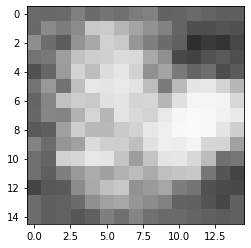

In [1240]:
plt.imshow(cv2.cvtColor(model.predictor.att.data[0][0], cv2.COLOR_BGR2RGB))

In [1241]:
heatmap = cv2.resize(model.predictor.att.data[0][0], (224, 224))
heatmap = cv2.applyColorMap(np.uint8(heatmap*255), cv2.COLORMAP_JET)
image = img[0, :].transpose(1, 2, 0) * 255
image -= np.min(image)
image = np.minimum(image, 255)
cam_img = np.float32(heatmap) + np.float32(image)
cam_img = 255 * cam_img / np.max(cam_img)

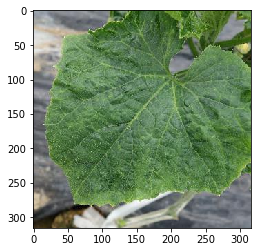

In [1242]:
plt.imshow(cv2.cvtColor(row_img, cv2.COLOR_BGR2RGB))

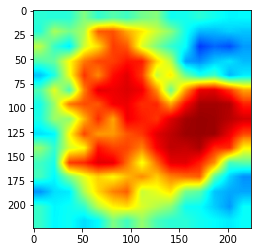

In [1243]:
plt.imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB))

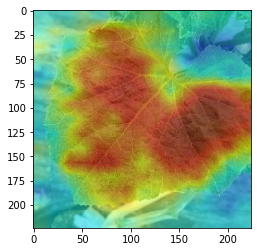

In [1244]:
plt.imshow(cv2.cvtColor(cam_img / 255, cv2.COLOR_BGR2RGB))

In [1245]:
from PIL import Image
import numpy as np

im = np.array(Image.open('center_attention_map.jpg'))

In [1246]:
img_gbr = cv2.imread('center_attention_map.jpg')
img_gray = cv2.cvtColor(img_gbr, cv2.COLOR_BGR2GRAY)

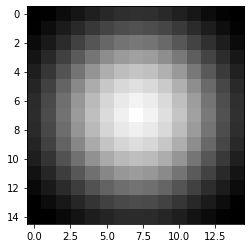

In [1247]:
plt.imshow(cv2.cvtColor(img_gray, cv2.COLOR_BGR2RGB))

In [1248]:
img_gray

array([[  0,   1,  12,  21,  31,  40,  46,  48,  47,  41,  32,  23,  12,
          3,   0],
       [  1,  13,  27,  41,  56,  68,  77,  81,  77,  70,  58,  43,  29,
         14,   3],
       [ 11,  25,  43,  65,  85, 103, 115, 120, 116, 105,  87,  67,  48,
         29,  11],
       [ 20,  40,  64,  90, 117, 141, 154, 160, 156, 142, 121,  94,  68,
         44,  23],
       [ 30,  54,  83, 116, 148, 174, 189, 196, 192, 176, 153, 120,  89,
         58,  33],
       [ 37,  65, 100, 137, 172, 199, 216, 223, 217, 202, 176, 142, 106,
         71,  41],
       [ 43,  73, 111, 150, 186, 214, 233, 243, 236, 218, 191, 157, 116,
         78,  47],
       [ 44,  76, 114, 155, 191, 219, 240, 255, 243, 223, 197, 161, 121,
         81,  48],
       [ 42,  72, 109, 149, 185, 213, 232, 240, 233, 217, 189, 155, 116,
         77,  46],
       [ 36,  65,  99, 135, 170, 196, 213, 221, 215, 199, 174, 141, 104,
         70,  41],
       [ 30,  52,  82, 113, 145, 170, 185, 191, 187, 173, 149, 117,  86,
       

In [1249]:
a = np.reshape(img_gray, (1, 1, 15, 15))

In [1250]:
x = Variable((a/255).astype(np.float32))

In [1254]:
x

variable([[[[0.        , 0.00392157, 0.04705882, 0.08235294, 0.12156863,
             0.15686275, 0.18039216, 0.1882353 , 0.18431373, 0.16078432,
             0.1254902 , 0.09019608, 0.04705882, 0.01176471, 0.        ],
            [0.00392157, 0.05098039, 0.10588235, 0.16078432, 0.21960784,
             0.26666668, 0.3019608 , 0.31764707, 0.3019608 , 0.27450982,
             0.22745098, 0.16862746, 0.11372549, 0.05490196, 0.01176471],
            [0.04313726, 0.09803922, 0.16862746, 0.25490198, 0.33333334,
             0.40392157, 0.4509804 , 0.47058824, 0.45490196, 0.4117647 ,
             0.34117648, 0.2627451 , 0.1882353 , 0.11372549, 0.04313726],
            [0.07843138, 0.15686275, 0.2509804 , 0.3529412 , 0.45882353,
             0.5529412 , 0.6039216 , 0.627451  , 0.6117647 , 0.5568628 ,
             0.4745098 , 0.36862746, 0.26666668, 0.17254902, 0.09019608],
            [0.11764706, 0.21176471, 0.3254902 , 0.45490196, 0.5803922 ,
             0.68235296, 0.7411765 , 0.76862746

In [1251]:
heatmap = cv2.resize(((model.predictor.att * x)).data[0][0], (224, 224))
heatmap = cv2.applyColorMap(np.uint8(heatmap*255), cv2.COLORMAP_JET)
image = img[0, :].transpose(1, 2, 0) * 255
image -= np.min(image)
image = np.minimum(image, 255)
cam_img = np.float32(heatmap) + np.float32(image)
cam_img = 255 * cam_img / np.max(cam_img)

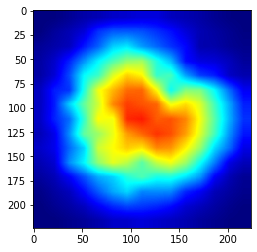

In [1252]:
plt.imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB))

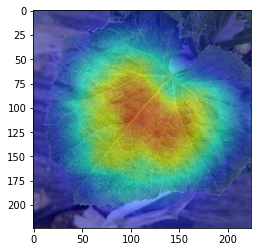

In [1253]:
plt.imshow(cv2.cvtColor(cam_img / 255, cv2.COLOR_BGR2RGB))

In [1232]:
heatmap = cv2.resize(x.data[0][0], (224, 224))
heatmap = cv2.applyColorMap(np.uint8(heatmap*255), cv2.COLORMAP_JET)
image = img[0, :].transpose(1, 2, 0) * 255
image -= np.min(image)
image = np.minimum(image, 255)
cam_img = np.float32(heatmap) + np.float32(image)
cam_img = 255 * cam_img / np.max(cam_img)

In [381]:
import chainer.functions as F


def kl_divergence(y, t):
    entropy = - F.sum(t[t.nonzero()] * F.log(t[t.nonzero()]))

    cross_entropy = - F.sum(t * F.log_softmax(y))

    return (cross_entropy - entropy) / y.shape[0]